In [1]:
import pandas as pd
import numpy as np
import nltk
import gensim
import spacy
from tqdm import tqdm
tqdm.pandas()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


SEED = 42
np.random.seed(SEED)

In [2]:
df = pd.read_csv('Tweets.csv')[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [3]:
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [4]:
# tokenize text

import spacy


spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]            

df['text'] = df['text'].progress_apply(str.lower)
df['text'] = df['text'].progress_apply(tokenizer)

100%|██████████████████████████████████| 14640/14640 [00:01<00:00, 11708.66it/s]


In [5]:
# encode classes

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['airline_sentiment'] = le.fit_transform(df.airline_sentiment.values)

In [6]:
df.head()

,text,airline_sentiment
0,"[what, said]",1
1,"[plus, you, added, commercials, to, the, exper...",2
2,"[i, did, today, must, mean, i, need, to, take,...",1
3,"[it, really, aggressive, to, blast, obnoxious,...",0
4,"[and, it, a, really, big, bad, thing, about, it]",0


In [7]:
# text preprocessing
import nltk


stopwords = nltk.corpus.stopwords.words('english')

df['text'] = df['text'].progress_apply(lambda x: [t for t in x if t not in stopwords])

100%|██████████████████████████████████| 14640/14640 [00:00<00:00, 60251.99it/s]


In [8]:
stemmer = nltk.SnowballStemmer('english')

df['text'] = df['text'].progress_apply(lambda x: [stemmer.stem(t) for t in x])

100%|██████████████████████████████████| 14640/14640 [00:00<00:00, 15484.81it/s]


In [9]:
df.head()

,text,airline_sentiment
0,[said],1
1,"[plus, ad, commerci, experi, tacki]",2
2,"[today, must, mean, need, take, anoth, trip]",1
3,"[realli, aggress, blast, obnoxi, entertain, gu...",0
4,"[realli, big, bad, thing]",0


In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, stratify=df.airline_sentiment.values, random_state=SEED)
len(df_train), len(df_test)

(13176, 1464)

In [11]:
from collections import Counter

class Vocab:
    def __init__(self, texts, min_freq=5):
        self.tokens = {'<pad>': 0, '<bos>':1, '<eos>': 2, '<unk>': 3}
        
        tokens = Counter()
        for text in texts:
            tokens.update(text)
            
        i = len(self.tokens)
        for t, freq in tokens.items():
            if freq >= min_freq:
                self.tokens[t] = i
                i += 1
            
    def encode(self, text):
        return [1] + [self.tokens.get(t, 3) for t in text] + [2]
    
    
vocab = Vocab(df_train.text)

df_train['text'] = df_train['text'].progress_apply(vocab.encode)
df_test['text'] = df_test['text'].progress_apply(vocab.encode)

print(len(vocab.tokens))

100%|███████████████████████████████████| 1464/1464 [00:00<00:00, 400290.81it/s]

2114


In [12]:
df_train.head()

,text,airline_sentiment
14317,"[1, 4, 5, 6, 2]",0
6790,"[1, 7, 8, 9, 10, 11, 12, 2]",1
2840,"[1, 13, 14, 15, 2]",2
378,"[1, 16, 17, 18, 19, 20, 7, 21, 22, 23, 24, 2]",2
3047,"[1, 25, 26, 2]",0


/home/denaas/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text', ylabel='Density'>

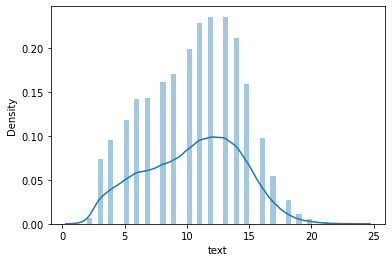

In [13]:
import seaborn as sns


sns.distplot(df_train.text.apply(len))

In [14]:
max_len = 20

df_train['text'] = df_train['text'].progress_apply(lambda x: x[:max_len] + [0]*max(max_len-len(x), 0))
df_test['text'] = df_test['text'].progress_apply(lambda x: x[:max_len] + [0]*max(max_len-len(x), 0))

100%|███████████████████████████████████| 1464/1464 [00:00<00:00, 828560.39it/s]


In [15]:
df_train.head()

,text,airline_sentiment
14317,"[1, 4, 5, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
6790,"[1, 7, 8, 9, 10, 11, 12, 2, 0, 0, 0, 0, 0, 0, ...",1
2840,"[1, 13, 14, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
378,"[1, 16, 17, 18, 19, 20, 7, 21, 22, 23, 24, 2, ...",2
3047,"[1, 25, 26, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0


In [16]:
from torch.utils.data import TensorDataset, DataLoader

ds_train = TensorDataset(
    torch.tensor(np.vstack(df_train.text.values)).long(),
    torch.tensor(df_train.airline_sentiment.values).long()
)

ds_test = TensorDataset(
    torch.tensor(np.vstack(df_test.text.values)).long(),
    torch.tensor(df_test.airline_sentiment.values).long()
)

In [17]:
loaders = {
    "train": DataLoader(ds_train, batch_size=64, shuffle=True),
    "valid": DataLoader(ds_test, batch_size=64, shuffle=False),
}

In [18]:
class TextClassifier(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=0) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.max_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = torch.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [19]:
model = TextClassifier(len(vocab.tokens),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4]
               )

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [20]:
from catalyst import dl


runner = dl.SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=10,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1,), num_classes=3),
    ],
    logdir="./logs",
    valid_loader="valid",
    valid_metric="loss",
    verbose=True,
    load_best_on_end=True,
#     check=True,
)

1/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (1/10) accuracy01: 0.7096994537690515 | accuracy01/std: 0.07379301649628364 | loss: 0.6904350530399144 | loss/mean: 0.6904350530399144 | loss/std: 0.12362614573568596 | lr: 0.001 | momentum: 0.9


1/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (1/10) accuracy01: 0.7520491806535773 | accuracy01/std: 0.04465987189658219 | loss: 0.6248541415714827 | loss/mean: 0.6248541415714827 | loss/std: 0.06730973405453063 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) 


2/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (2/10) accuracy01: 0.8014571951531464 | accuracy01/std: 0.05188763026471395 | loss: 0.4956191369599839 | loss/mean: 0.4956191369599839 | loss/std: 0.08601986689566513 | lr: 0.001 | momentum: 0.9


2/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (2/10) accuracy01: 0.7732240453443893 | accuracy01/std: 0.0336522681276512 | loss: 0.5920894986293356 | loss/mean: 0.5920894986293356 | loss/std: 0.07678701051534112 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) 


3/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (3/10) accuracy01: 0.8636915604852512 | accuracy01/std: 0.041635990148281364 | loss: 0.3587740287139479 | loss/mean: 0.3587740287139479 | loss/std: 0.06644045654196305 | lr: 0.001 | momentum: 0.9


3/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (3/10) accuracy01: 0.7786885258929978 | accuracy01/std: 0.05624178437974299 | loss: 0.5986941922557809 | loss/mean: 0.5986941922557809 | loss/std: 0.10933719111996376 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) 


4/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (4/10) accuracy01: 0.9215998786756615 | accuracy01/std: 0.03184508149899819 | loss: 0.24195342743005913 | loss/mean: 0.24195342743005913 | loss/std: 0.05510725827853049 | lr: 0.001 | momentum: 0.9


4/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (4/10) accuracy01: 0.7616120234864657 | accuracy01/std: 0.05156239254068643 | loss: 0.6473974973126189 | loss/mean: 0.6473974973126189 | loss/std: 0.11851445387003226 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) 


5/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (5/10) accuracy01: 0.9603066182020726 | accuracy01/std: 0.02448881634366104 | loss: 0.1549410431509533 | loss/mean: 0.1549410431509533 | loss/std: 0.05035742155255228 | lr: 0.001 | momentum: 0.9


5/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (5/10) accuracy01: 0.7711748650165203 | accuracy01/std: 0.04662669241406192 | loss: 0.6855283193900937 | loss/mean: 0.6855283193900937 | loss/std: 0.1456179748084393 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) 


6/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (6/10) accuracy01: 0.9748026716687425 | accuracy01/std: 0.0203996150116564 | loss: 0.10819447359028336 | loss/mean: 0.10819447359028336 | loss/std: 0.052202417594088904 | lr: 0.001 | momentum: 0.9


6/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (6/10) accuracy01: 0.764344264575041 | accuracy01/std: 0.04866218027898639 | loss: 0.7444165580259647 | loss/mean: 0.7444165580259647 | loss/std: 0.17208778523799234 | lr: 0.001 | momentum: 0.9
* Epoch (6/10) 


7/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (7/10) accuracy01: 0.9793564055859142 | accuracy01/std: 0.017309422732202637 | loss: 0.08831411069931955 | loss/mean: 0.08831411069931955 | loss/std: 0.04788148928319087 | lr: 0.001 | momentum: 0.9


7/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (7/10) accuracy01: 0.7547814217421527 | accuracy01/std: 0.058382266869173804 | loss: 0.8287386421948835 | loss/mean: 0.8287386421948835 | loss/std: 0.18445740531290103 | lr: 0.001 | momentum: 0.9
* Epoch (7/10) 


8/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (8/10) accuracy01: 0.9829993928354586 | accuracy01/std: 0.016739694771276424 | loss: 0.07574061577111652 | loss/mean: 0.07574061577111652 | loss/std: 0.05231631858159359 | lr: 0.001 | momentum: 0.9


8/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (8/10) accuracy01: 0.7732240453443892 | accuracy01/std: 0.05429635109351006 | loss: 0.8081279582664614 | loss/mean: 0.8081279582664614 | loss/std: 0.2015108839924524 | lr: 0.001 | momentum: 0.9
* Epoch (8/10) 


9/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (9/10) accuracy01: 0.9813296903460835 | accuracy01/std: 0.017896187725734588 | loss: 0.08031012110285456 | loss/mean: 0.08031012110285456 | loss/std: 0.06361253184176442 | lr: 0.001 | momentum: 0.9


9/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (9/10) accuracy01: 0.760928964028593 | accuracy01/std: 0.05154904982615156 | loss: 0.8505249072293765 | loss/mean: 0.8505249072293765 | loss/std: 0.20771392817708423 | lr: 0.001 | momentum: 0.9
* Epoch (9/10) 


10/10 * Epoch (train):   0%|          | 0/206 [00:00<?, ?it/s]

train (10/10) accuracy01: 0.9848967823174481 | accuracy01/std: 0.0164000433780252 | loss: 0.06886493845751741 | loss/mean: 0.06886493845751741 | loss/std: 0.06693190916791684 | lr: 0.001 | momentum: 0.9


10/10 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (10/10) accuracy01: 0.771174864690812 | accuracy01/std: 0.04806077865034212 | loss: 0.8936345697752113 | loss/mean: 0.8936345697752113 | loss/std: 0.2110949437705731 | lr: 0.001 | momentum: 0.9
* Epoch (10/10) 
Top best models:
logs/checkpoints/train.2.pth	0.5921
